<a href="https://colab.research.google.com/github/Yogs05/Task/blob/main/end_of_TK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install seqeval

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from collections import Counter, defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch.nn import CrossEntropyLoss

#### **Eksplorasi Dataset**

In [ ]:
df = pd.read_csv(f'iphone.csv')
df

,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
...,...,...,...,...,...,...,...,...,...,...,...
3057,B09G9D8KRQ,India,11-10-2023,True,1,Very bad experience with i phone 13,Useless phon never buy this heat n useless cam...,https://www.amazon.in/gp/customer-reviews/R10O...,Reviewed in India on 11 October 2023,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N
3058,B09G9D8KRQ,India,14-10-2022,True,2,not happy with this apple product,iam not happy with this product why because ch...,https://www.amazon.in/gp/customer-reviews/R2FW...,Reviewed in India on 14 October 2022,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N
3059,B09G9D8KRQ,India,24-02-2022,True,3,Good phone,Good phone,https://www.amazon.in/gp/customer-reviews/R2C7...,Reviewed in India on 24 February 2022,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N
3060,B09G9D8KRQ,India,16-10-2023,True,1,Battery discharge,While charging mobile it's getting so hot even...,https://www.amazon.in/gp/customer-reviews/R3K0...,Reviewed in India on 16 October 2023,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N


In [ ]:
def data_summary(data):
    info = data.info()
    description = data.describe()

    return info,description

info,description = data_summary(df)
print(info)
print(description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   productAsin        3062 non-null   object
 1   country            3062 non-null   object
 2   date               3062 non-null   object
 3   isVerified         3062 non-null   bool  
 4   ratingScore        3062 non-null   int64 
 5   reviewTitle        3062 non-null   object
 6   reviewDescription  2976 non-null   object
 7   reviewUrl          3046 non-null   object
 8   reviewedIn         3062 non-null   object
 9   variant            3062 non-null   object
 10  variantAsin        3062 non-null   object
dtypes: bool(1), int64(1), object(9)
memory usage: 242.3+ KB
None
       ratingScore
count  3062.000000
mean      3.758981
std       1.579033
min       1.000000
25%       3.000000
50%       5.000000
75%       5.000000
max       5.000000


In [ ]:
data = {
    "ASIN": [
        "B09G9BL5CP", "B09P82T3PZ", "B09G9J5JZX",
        "B0CHX1W1XY", "B0BDK8LKPJ", "B0BN72MLT2", "B09G9D8KRQ"
    ],
    "Model iPhone": [
        "iPhone 13", "iPhone 13 (Refurbished)", "iPhone 13",
        "iPhone 15", "iPhone 14", "iPhone 14 (Renewed)", "iPhone 13"
    ],
    "Kapasitas": [
        "128 GB", "128 GB", "256 GB",
        "128 GB", "128 GB", "256 GB", "128 GB"
    ],
    "Warna": [
        "Biru", "Starlight", "Midnight",
        "Hitam", "Starlight", "Midnight", "Starlight"
    ],

}

df_produk = pd.DataFrame(data)
df_produk


,ASIN,Model iPhone,Kapasitas,Warna
0,B09G9BL5CP,iPhone 13,128 GB,Biru
1,B09P82T3PZ,iPhone 13 (Refurbished),128 GB,Starlight
2,B09G9J5JZX,iPhone 13,256 GB,Midnight
3,B0CHX1W1XY,iPhone 15,128 GB,Hitam
4,B0BDK8LKPJ,iPhone 14,128 GB,Starlight
5,B0BN72MLT2,iPhone 14 (Renewed),256 GB,Midnight
6,B09G9D8KRQ,iPhone 13,128 GB,Starlight


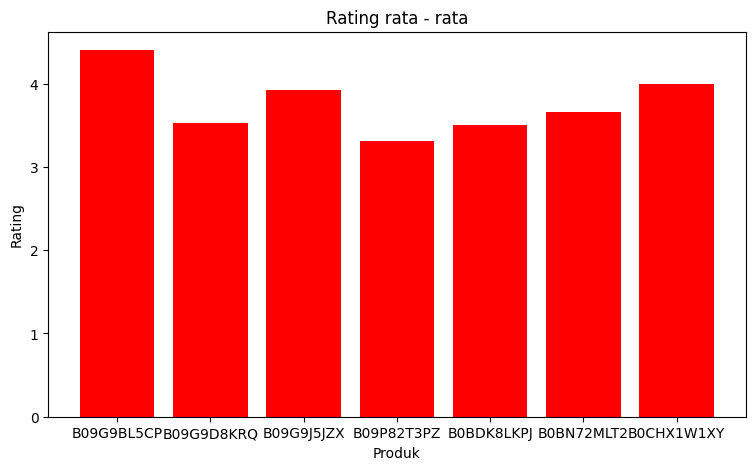

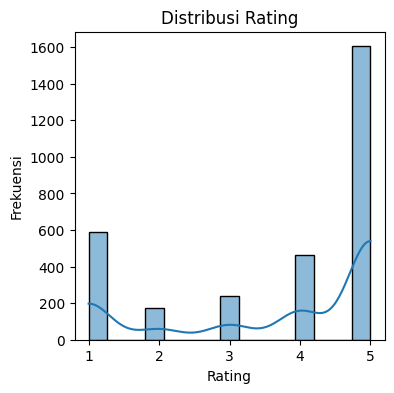

In [ ]:
def bar_chart(df):
    plt.figure(figsize=(9,5))
    average_price_by_make = df.groupby('productAsin')['ratingScore'].mean()
    plt.bar(average_price_by_make.index, average_price_by_make.values,color='red')
    plt.title('Rating rata - rata')
    plt.xlabel('Produk')
    plt.ylabel('Rating')
    plt.show()

def histplot(df):
    plt.figure(figsize=(4,4))
    sns.histplot(df['ratingScore'], kde=True)
    plt.title('Distribusi Rating')
    plt.xlabel('Rating')
    plt.ylabel('Frekuensi')
    plt.show()




bar_chart(df)
histplot(df)

In [ ]:
df.drop(['productAsin', 'country', 'date', 'isVerified',
       'reviewTitle', 'reviewUrl', 'reviewedIn',
       'variant', 'variantAsin'], axis = 1, inplace = True)
df.head()

,ratingScore,reviewDescription
0,4,"Every thing is good about iPhones, there's not..."
1,5,"It look so fabulous, I am android user switche..."
2,4,I tried to flip camera while recording but no ...
3,5,100% genuine
4,5,Happy to get the iPhone 13 in Amazon offer


#### Data Cleaning untuk Deteksi Aspek

Melabelkan Aspek menggunakan Teknik Bio-Tagging

In [ ]:
import pandas as pd
import re

aspect_keywords = {
    "camera": ["camera", "photo", "picture", "lens", "video", "zoom", "blur", "record"],
    "battery": ["battery", "power", "charging", "charge", "charger"],
    "performance": ["performance", "smooth", "responsive", "lag"],
    "screen": ["screen", "display", "resolution", "scratches"],
    "price": ["price", "expensive", "cheap", "worth", "value", "pay"]
}

keyword_to_aspect = {kw: aspect for aspect, kws in aspect_keywords.items() for kw in kws}

def tokenize(text):
    return re.findall(r"\w+|[^\w\s]", text.lower())

def label_bio(text):
    tokens = tokenize(text)
    labels = ["O"] * len(tokens)
    for i, token in enumerate(tokens):
        for keyword, aspect in keyword_to_aspect.items():
            if token == keyword:
                labels[i] = f"B-{aspect.upper()}"
    return tokens, labels

def save_bio_format(data, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for tokens, labels in data:
            for token, label in zip(tokens, labels):
                f.write(f"{token} {label}\n")
            f.write("\n")

df_clean = df[df["reviewDescription"].notnull()]

# Proses tagging
bio_tagged_data = [label_bio(str(text)) for text in df_clean["reviewDescription"]]

# Simpan ke file
save_bio_format(bio_tagged_data, "bio_tagged_dataset.txt")


In [ ]:
def load_bio_txt_to_list(file_path):
    data = []
    tokens = []
    labels = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    data.append({"tokens": tokens, "labels": labels})
                    tokens = []
                    labels = []
            else:
                parts = line.split()
                if len(parts) == 2:
                    tokens.append(parts[0])
                    labels.append(parts[1])
    return data

data = load_bio_txt_to_list("bio_tagged_dataset.txt")

In [ ]:
def oversample_aspect_data(data, factor=5):
    aspect_data = [d for d in data if any("B-" in tag for tag in d["labels"])]
    return data + aspect_data * factor

data = oversample_aspect_data(data, factor=5)

#### Tokenisasi serta Data Splitting Deteksi Aspek

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
label_list = sorted({label for d in data for label in d["labels"]})
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding=False
    )
    word_ids = tokenized.word_ids()
    label_ids = []
    prev_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != prev_word_idx:
            label_ids.append(label2id[example["labels"][word_idx]])
        else:
            label_ids.append(-100)
        prev_word_idx = word_idx
    tokenized["labels"] = label_ids
    return tokenized

train_tokenized = train_dataset.map(tokenize_and_align_labels)
test_tokenized = test_dataset.map(tokenize_and_align_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/7960 [00:00<?, ? examples/s]

Map:   0%|          | 0/1991 [00:00<?, ? examples/s]

#### Model Training untuk Deteksi Aspek

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(-1)
    true_labels = []
    true_preds = []
    for pred, label in zip(preds, labels):
        temp_true, temp_pred = [], []
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                temp_true.append(id2label[l_])
                temp_pred.append(id2label[p_])
        true_labels.append(temp_true)
        true_preds.append(temp_pred)
    return {
        "accuracy": accuracy_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
    }


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="bert-aspect-model",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="logs",
    report_to="none"  # disable wandb
)

# --- STEP 10: Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# --- STEP 11: Train model ---
trainer.train()

<ipython-input-17-a185030d848f>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001100,0.000008,1.000000,1.000000,1.000000,1.000000
2,0.000200,0.000004,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000003,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=2985, training_loss=0.0003412882859820197, metrics={'train_runtime': 1090.7968, 'train_samples_per_second': 21.892, 'train_steps_per_second': 2.737, 'total_flos': 2595672950638752.0, 'train_loss': 0.0003412882859820197, 'epoch': 3.0})

#### Model Evaluation untuk Aspek Detection

In [ ]:
trainer.evaluate()

{'eval_loss': 3.1358556498162216e-06,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 25.096,
 'eval_samples_per_second': 79.335,
 'eval_steps_per_second': 9.922,
 'epoch': 3.0}

#### Inference Model untuk Klasifikasi Aspek


In [ ]:
def predict_aspects(text, model, tokenizer, id2label):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    words = text.split()
    batch = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True)
    word_ids = batch.word_ids()  # Ambil sebelum pindah ke device
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1).squeeze().tolist()

    results = []
    seen = set()
    for i, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx not in seen:
            label = id2label[predictions[i]]
            results.append((words[word_idx], label))
            seen.add(word_idx)

    return results


In [ ]:
text = "battery and camera are good but the price is too expensive"
predictions = predict_aspects(text, model, tokenizer, id2label)

for token, label in predictions:
    print(f"{token}: {label}")


battery: B-BATTERY
and: O
camera: B-CAMERA
are: O
good: O
but: O
the: O
price: B-PRICE
is: O
too: O
expensive: B-PRICE


####Data Cleaning untuk Klasifikasi Sentiment

In [ ]:
import pandas as pd
data1 = pd.read_csv('Bert_Patapim.csv')
data2 = pd.read_csv('Bert_Patapim2.csv')

data = pd.concat([data1, data2], ignore_index=True)

In [ ]:
data

,annotation_id,annotator,aspect,created_at,id,lead_time,sentiment,text,updated_at
0,2,1,price,2025-05-30T02:56:28.763924Z,2000,24.476,Positive,"So beautiful,So elegant,just looking like a wo...",2025-05-30T02:56:28.763937Z
1,3,1,general,2025-05-30T02:56:41.159656Z,2001,10.113,Positive,No problem in this mobile 14.Also Quick servic...,2025-05-30T02:56:41.159668Z
2,4,1,general,2025-05-30T02:56:47.209615Z,2002,4.516,Positive,What to write of an iPhone?? Best as always,2025-05-30T02:56:47.209627Z
3,5,1,battery,2025-05-30T02:56:51.873195Z,2003,3.336,Positive,"very good sound quality,....smooth, and good b...",2025-05-30T02:56:51.873205Z
4,6,1,performance,2025-05-30T02:56:56.369109Z,2004,3.346,Positive,"very good sound quality,....smooth, and good b...",2025-05-30T02:56:56.369120Z
...,...,...,...,...,...,...,...,...,...
2789,1989,1,general,2025-05-30T07:25:53.227797Z,1995,1.738,Positive,best,2025-05-30T07:25:53.227797Z
2790,1990,1,general,2025-05-30T07:26:03.857234Z,1996,0.707,Positive,Love this product,2025-05-30T07:26:03.857234Z
2791,1991,1,general,2025-05-30T07:26:08.309071Z,1997,0.690,Positive,Awesome variant,2025-05-30T07:26:08.309071Z
2792,1992,1,performance,2025-05-30T07:26:19.872466Z,1998,8.141,Positive,Main advantage is ease of use and performance....,2025-05-30T07:26:19.872466Z


#### Labeling untuk Klasifikasi Sentiment

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["sentiment"].str.lower())



In [ ]:
data = data[data["label"] != 3].reset_index(drop=True)

In [ ]:
data["input_text"] = data.apply(lambda x: f"{x['text']} [SEP] {x['aspect']}",axis=1)

#### Splitting dan Tokenisasi untuk Klasifikasi Sentiment

In [ ]:
train_data_sentiment, test_data_sentiment = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
tokenizer_sentiment = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_sentiment(example):
    return tokenizer_sentiment(example["input_text"], padding="max_length", truncation=True)

In [ ]:
train_dataset_sentiment = Dataset.from_pandas(train_data_sentiment[["input_text", "label"]])
test_dataset_sentiment = Dataset.from_pandas(test_data_sentiment[["input_text", "label"]])

train_tokenized_sentiment = train_dataset_sentiment.map(tokenize_sentiment, batched=True)
test_tokenized_sentiment = test_dataset_sentiment.map(tokenize_sentiment, batched=True)

Map:   0%|          | 0/2233 [00:00<?, ? examples/s]

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_names = label_encoder.classes_
weights = compute_class_weight(class_weight='balanced', classes=np.unique(data["label"]), y=data["label"])
class_weights = torch.tensor(weights, dtype=torch.float)

In [ ]:
import torch.nn as nn

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Added num_items_in_batch
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # loss function for classification
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

def compute_metrics_sentiment(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)
    return {
        "accuracy": (preds == labels).mean(),
    }

#### Model Training untuk Klasifikasi Sentiment

In [ ]:
from transformers import BertForSequenceClassification

model_sentiment = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_sentiment = TrainingArguments(
    output_dir="./bert-absa-sentiment",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    report_to="none",
    logging_dir="logs_sentiment",
    logging_steps=10,
)

trainer_sentiment = WeightedTrainer(
    model=model_sentiment,
    args=training_args_sentiment,
    train_dataset=train_tokenized_sentiment,
    eval_dataset=test_tokenized_sentiment,
    tokenizer=tokenizer_sentiment,
    class_weights=class_weights,
    compute_metrics=compute_metrics_sentiment
)

<ipython-input-34-9f7d3814a55a>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
trainer_sentiment.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.389700,0.875628,0.830054
2,0.691400,0.692273,0.801431
3,0.557500,0.621908,0.835420
4,0.126900,1.022646,0.821109
5,0.389500,1.033371,0.844365
6,0.036200,1.352590,0.838998
7,0.152200,1.137519,0.821109
8,0.141100,1.320611,0.831843
9,0.150000,1.378974,0.849732
10,0.101000,1.430977,0.840787


TrainOutput(global_step=2800, training_loss=0.378962216148419, metrics={'train_runtime': 2253.6535, 'train_samples_per_second': 9.908, 'train_steps_per_second': 1.242, 'total_flos': 5875322617866240.0, 'train_loss': 0.378962216148419, 'epoch': 10.0})

#### Model Evaluation untuk Sentiment Analysis

In [ ]:
trainer_sentiment.evaluate()

{'eval_loss': 1.430977463722229,
 'eval_accuracy': 0.8407871198568873,
 'eval_runtime': 15.6104,
 'eval_samples_per_second': 35.809,
 'eval_steps_per_second': 4.484,
 'epoch': 10.0}

#### Model Inference untuk Sentiment Analysis

In [ ]:
def predict_sentiment(text, aspect, model, tokenizer, label_encoder):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    input_text = f"{text} [SEP] {aspect}"
    inputs = tokenizer(input_text, padding="max_length", truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    predicted_label_index = torch.argmax(probabilities, dim=1).item()
    predicted_sentiment = label_encoder.inverse_transform([predicted_label_index])[0]

    return predicted_sentiment



In [ ]:
review = "good battery and screen is so smooth"
aspect = "battery"
predicted_sentiment = predict_sentiment(review, aspect, model_sentiment, tokenizer_sentiment, label_encoder)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: positive


#### Memprediksi menggunakan kedua Model (Model Deteksi Aspek dan Model Deteksi Sentiment)

In [ ]:
text = 'screen and camera are good,  the battery drains too quickly, and the price is okay'
predictions = predict_aspects(text, model, tokenizer, id2label)

print(text)

print('-'*80)

if any("B-" in label for token, label in predictions):
    for token, label in predictions:
        if "B-" in label:
            aspect = label.replace("B-", "").lower()
            predicted_sentiment = predict_sentiment(text, aspect, model_sentiment, tokenizer_sentiment, label_encoder)
            print(f"Aspect: {aspect}, Predicted Sentiment: {predicted_sentiment}")

else:
  predicted_sentiment = predict_sentiment(text, token, model_sentiment, tokenizer_sentiment, label_encoder)
  print(f"Aspek umum dengan Sentiment {predicted_sentiment}")


screen and camera are good,  the battery drains too quickly, and the price is okay
--------------------------------------------------------------------------------
Aspect: screen, Predicted Sentiment: positive
Aspect: camera, Predicted Sentiment: positive
Aspect: battery, Predicted Sentiment: negative
Aspect: price, Predicted Sentiment: positive


#### Plot loss dan Akurasi untuk Model Aspek

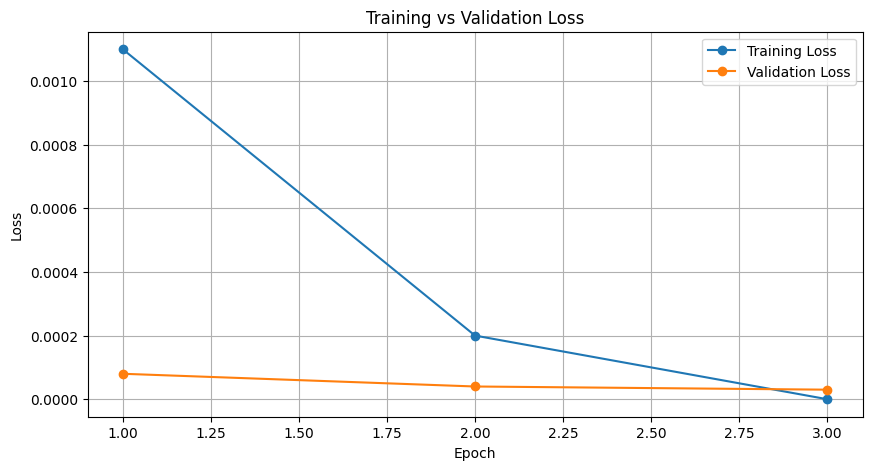

In [ ]:
import matplotlib.pyplot as plt

epoch = [1, 2, 3]
training_loss = [0.0011, 0.0002, 0.0]
validation_loss = [0.00008, 0.00004, 0.00003]
accuracy = [1.0, 1.0, 1.0]
f1 = [1.0, 1.0, 1.0]
precision = [1.0, 1.0, 1.0]
recall = [1.0, 1.0, 1.0]

plt.figure(figsize=(10, 5))
plt.plot(epoch, training_loss, label='Training Loss', marker='o')
plt.plot(epoch, validation_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Plot loss dan Akurasi untuk Model Sentiment

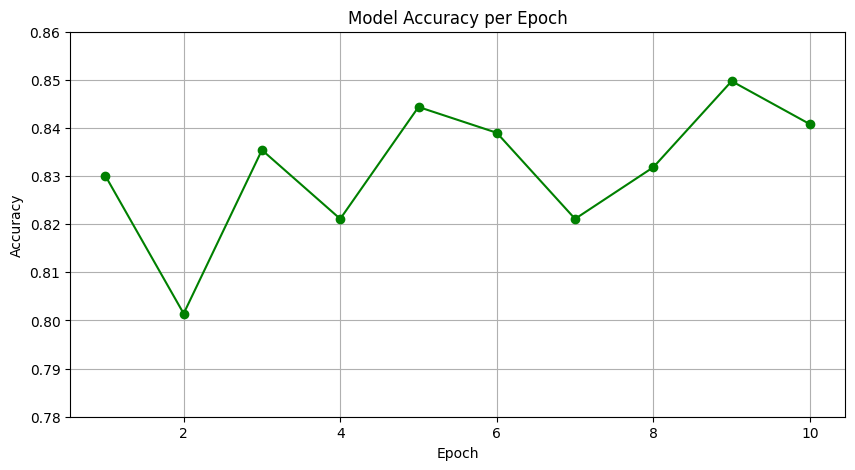

In [ ]:
import matplotlib.pyplot as plt

# Data
epoch = list(range(1, 11))
accuracy = [0.830054, 0.801431, 0.83542, 0.821109, 0.844365, 0.838998, 0.821109, 0.831843, 0.849732, 0.840787]


# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch, accuracy, label='Accuracy', color='green', marker='o')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.78, 0.86)
plt.grid(True)
plt.show()
